<a href="https://colab.research.google.com/github/shivanishah/satellite-image/blob/main-v2.2/satellite_pre_processing_06_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.10.12


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import csv
import cv2

In [ ]:
!pip install Pillow
!pip install numpy
!pip install rasterio
!pip install matplotlib
!pip install scikit-learn
!pip install patchify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 83.6 MB/s eta 0:00:00


In [ ]:
#if you have issue while installing tensorflow and segmentation models
!pip uninstall -y segmentation-models efficientnet image-classifiers keras tensorflow

In [ ]:
!pip install tensorflow==2.9.1 keras==2.9.0
!pip install segmentation-models==1.0.1
!pip install efficientnet==1.0.0 image-classifiers==1.0.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 48.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 24.3.25
    Uninstalling flatbuffers-24.3.25:
      Successfully uninstalled flatbuffers-24.3.25
  Attempting uninstall: tensorflow-estimat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.1 MB/s eta 0:00:00


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.merge import merge
from PIL import Image
from patchify import patchify
import segmentation_models as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import random

Segmentation Models: using `keras` framework.


In [ ]:
# Define the input and output folder paths
base_input_folder = "drive/MyDrive/Colab Notebooks/satellite"
categories = ["Farm", "Dense Residential", "Forest"] #"Sparse Residential"
label_mapping = {
  'farm': 0,
  'dense residential': 1,
  'forest': 2
  #'sparse residential': 3
}
color_mapping = {
    0: [144/255, 238/255, 144/255],  # Light green for Farm
    1: [0/255, 0/255, 139/255],      # Dark blue for Dense Residential
    2: [0/255, 100/255, 0/255]      # Dark green for Forest
    #3: [135/255, 206/255, 250/255]   # Light blue for Sparse Residential
}

In [ ]:
def apply_color_mapping(mask):
  # Create an empty RGB image
  colored_mask = np.zeros((*mask.shape, 3), dtype=np.float32)
  # Apply color mapping
  for label, color in color_mapping.items():
      colored_mask[mask == label] = color
  return colored_mask

In [ ]:
minmaxscaler = MinMaxScaler()
patch_size = 128

In [ ]:
# Initialize an empty list to store labels from masks
labels_dataset = []
# Initialize an empty list to store patches from images
image_dataset = []
# Initialize an empty list to store mask from images,labels
mask_dataset = []

# Iterate over each category to process image
for category in categories:
    # Construct the path to the pngImage folder within each category
    image_folder = os.path.join(base_input_folder, category, "pngImage")

    # Check if the folder exists before proceeding
    if not os.path.exists(image_folder):
        print(f"Warning: {image_folder} does not exist, skipping.")
        continue

    # List and process all PNG images in the folder
    images = sorted(os.listdir(image_folder))
    for i, image_name in enumerate(images):
        if image_name.endswith(".png"):  # Only process PNG images
            image_path = os.path.join(image_folder, image_name)

            # Read and process the image
            image = cv2.imread(image_path, 1)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #base 10 (decimal) colors

            # Check if the image dimensions are smaller than the patch size
            if image.shape[0] < patch_size or image.shape[1] < patch_size:
                print(f"Warning: Image {image_path} is smaller than patch size, skipping.")
                continue

            SIZE_X = (image.shape[1] // patch_size) * patch_size  # Nearest size divisible by patch size
            SIZE_Y = (image.shape[0] // patch_size) * patch_size  # Nearest size divisible by patch size

            # Crop the image to the nearest size divisible by patch size
            image = Image.fromarray(image)
            image = image.crop((0, 0, SIZE_X, SIZE_Y))
            image = np.array(image)

            # Extract patches from the image
            #print(f"Now patchifying mask: {image_path}")
            patches_image = patchify(image, (patch_size, patch_size, 3), step=patch_size)  # Step=128 means no overlap

            # Iterate through patches and add them to the dataset
            for i in range(patches_image.shape[0]):
                for j in range(patches_image.shape[1]):
                    individual_patched_image = patches_image[i,j,:,:]
                    #print(individual_patched_image.shape)
                    #normalise dataset with minmaxscaler
                    individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
                    individual_patched_image = individual_patched_image[0]
                    #print(individual_patched_image.shape)
                    image_dataset.append(individual_patched_image)

                    # Create mask patch
                    mask_patch = np.full((patch_size, patch_size), label_mapping.get(category.lower(), 0))
                    mask_dataset.append(mask_patch)

                    # Add the label to the dataset based on the category
                    labels_dataset.append(category.lower())

In [ ]:
print(f"Total number of image patches extracted: {len(image_dataset)}")
print(f"Total number of mask paches extracted: {len(mask_dataset)}")
print(f"Total number of label paches extracted: {len(labels_dataset)}")

Total number of image patches extracted: 1200
Total number of mask paches extracted: 1200
Total number of label paches extracted: 1200


In [ ]:
mask_dataset[500].shape

(128, 128)

In [ ]:
image_dataset[500].shape

(128, 128, 3)

In [ ]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
labels_dataset = np.array(labels_dataset)

In [ ]:
image_dataset[500]

array([[[0.9535865 , 0.91025641, 0.81702128],
        [0.92405063, 0.87606838, 0.79574468],
        [0.88185654, 0.86324786, 0.78297872],
        ...,
        [0.00843882, 0.02136752, 0.01276596],
        [0.01265823, 0.0042735 , 0.01702128],
        [0.092827  , 0.0042735 , 0.05106383]],

       [[0.92827004, 0.92735043, 0.85106383],
        [0.92405063, 0.90598291, 0.80425532],
        [0.87341772, 0.89316239, 0.78723404],
        ...,
        [0.02109705, 0.02564103, 0.03404255],
        [0.05485232, 0.04273504, 0.05957447],
        [0.24894515, 0.15384615, 0.14468085]],

       [[0.89029536, 0.92307692, 0.7787234 ],
        [0.86919831, 0.85897436, 0.76595745],
        [0.86919831, 0.85897436, 0.74893617],
        ...,
        [0.02109705, 0.02564103, 0.02553191],
        [0.08860759, 0.05982906, 0.08085106],
        [0.32489451, 0.26068376, 0.23404255]],

       ...,

       [[0.75527426, 0.73931624, 0.73617021],
        [0.92405063, 0.93589744, 0.83829787],
        [0.89873418, 0

#Data Augmentation

In [ ]:
from scipy import ndimage

In [ ]:
def apply_augmentation(image, mask):
  # Apply random rotations
  if np.random.rand() < 0.5:
    angle = np.random.randint(4) * 90
    image = ndimage.rotate(image, angle, reshape=False)
    mask = ndimage.rotate(mask, angle, reshape=False)

  # Apply vertical flips
  if np.random.rand() < 0.5:
    image = np.flip(image, 0)
    mask = np.flip(mask, 0)

  # Apply horizontal flips
  if np.random.rand() < 0.5:
    image = np.flip(image, 1)
    mask = np.flip(mask, 1)

  # Apply zooming
  if np.random.rand() < 0.5:
    zoom_factor = np.random.uniform(0.8, 1.2)
    image = ndimage.zoom(image, (zoom_factor, zoom_factor, 1), order=1)
    mask = ndimage.zoom(mask, (zoom_factor, zoom_factor), order=0)

  # Apply brightness adjustment
  if np.random.rand() < 0.5:
    brightness_factor = np.random.uniform(0.7, 1.3)
    image = np.clip(image * brightness_factor, 0, 1).astype(np.float32)

  # Apply contrast adjustment
  if np.random.rand() < 0.5:
    contrast_factor = np.random.uniform(0.7, 1.3)
    mean = np.mean(image, axis=(0, 1), keepdims=True)
    image = np.clip((image - mean) * contrast_factor + mean, 0, 1).astype(np.float32)

  # Resize the image and mask
  image = cv2.resize(image, (128, 128))  # Keeping the original size
  mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)

  return image, mask

In [ ]:
augmented_image_dataset = []
augmented_mask_dataset = []
augmented_labels_dataset = []

for image, mask, label in zip(image_dataset, mask_dataset, labels_dataset):
  # Add original image
  augmented_image_dataset.append(image)
  augmented_mask_dataset.append(mask)
  augmented_labels_dataset.append(label)

  # Add augmented image
  aug_image, aug_mask = apply_augmentation(image, mask)
  augmented_image_dataset.append(aug_image)
  augmented_mask_dataset.append(aug_mask)
  augmented_labels_dataset.append(label)

# Convert to numpy arrays
augmented_image_dataset = np.array(augmented_image_dataset)
augmented_mask_dataset = np.array(augmented_mask_dataset)
augmented_labels_dataset = np.array(augmented_labels_dataset)

# Print the new sizes
print(f"Augmented image dataset shape: {augmented_image_dataset.shape}")
print(f"Augmented mask dataset shape: {augmented_mask_dataset.shape}")
print(f"Augmented labels dataset shape: {augmented_labels_dataset.shape}")

Augmented image dataset shape: (2400, 128, 128, 3)
Augmented mask dataset shape: (2400, 128, 128)
Augmented labels dataset shape: (2400,)


In [ ]:
augmented_mask_dataset = np.expand_dims(augmented_mask_dataset, axis=3)
augmented_mask_dataset.shape

(2400, 128, 128, 1)

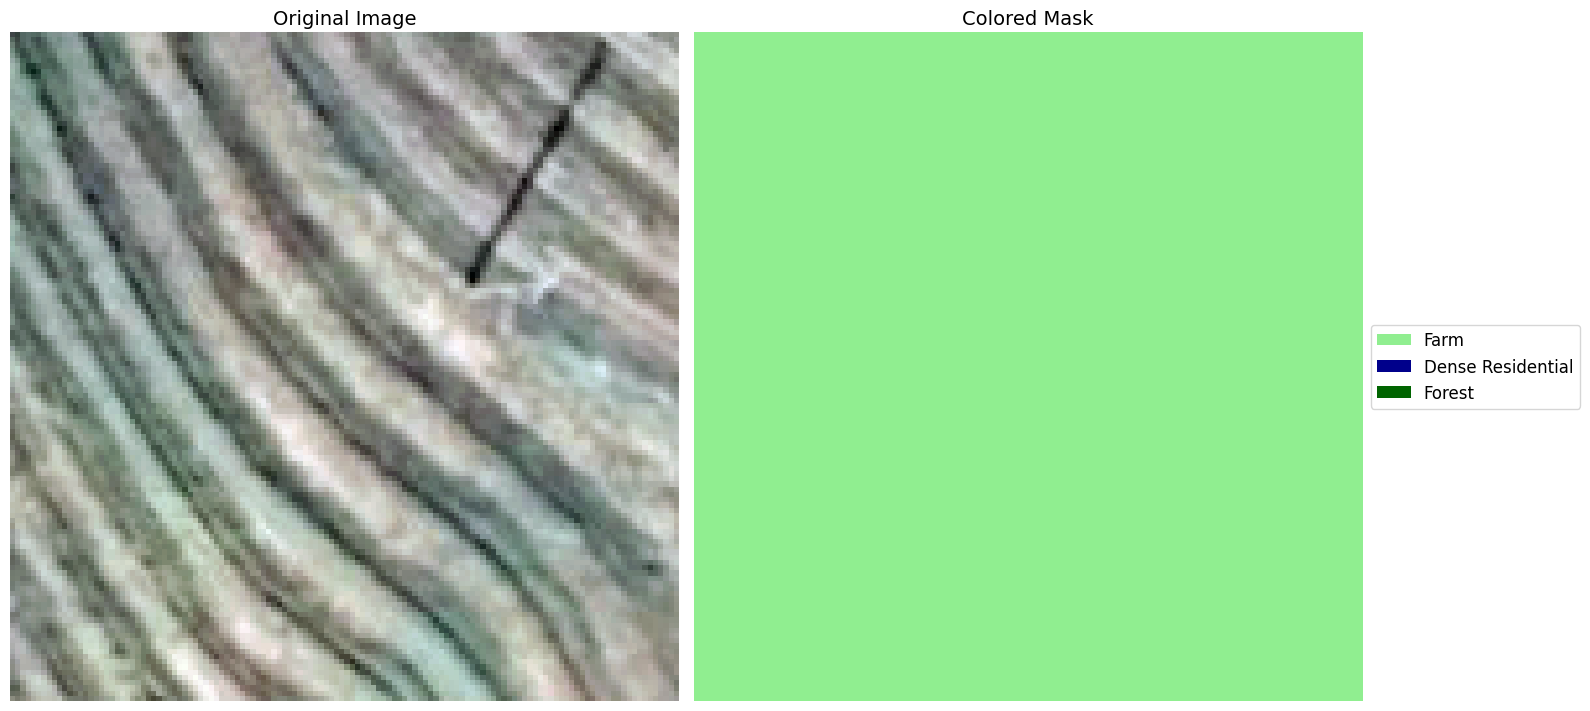

Category: Farm


In [ ]:
# Select a random image and its corresponding mask
random_image_id = random.randint(0, len(augmented_image_dataset) - 1)
random_image = augmented_image_dataset[random_image_id]
random_mask = augmented_mask_dataset[random_image_id]

# Apply color mapping to the mask
colored_mask = apply_color_mapping(random_mask)
# Squeeze the colored mask to remove the extra dimension
colored_mask = np.squeeze(colored_mask)

# Create the plot
plt.figure(figsize=(16, 8))

# Display original image
plt.subplot(121)
plt.title("Original Image", fontsize=14)
plt.imshow(random_image)
plt.axis('off')

# Display colored mask
plt.subplot(122)
plt.title("Colored Mask", fontsize=14)
plt.imshow(colored_mask)
plt.axis('off')

# Create a custom legend
legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=color_mapping[label_mapping[cat.lower()]], label=cat) for cat in categories]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

plt.tight_layout()
plt.show()

# Print the category of the selected image
print(f"Category: {categories[label_mapping[augmented_labels_dataset[random_image_id]]]}")

#EDA

In [ ]:
from collections import Counter

Class distribution:
farm: 400
dense residential: 400
forest: 400
sparse residential: 394


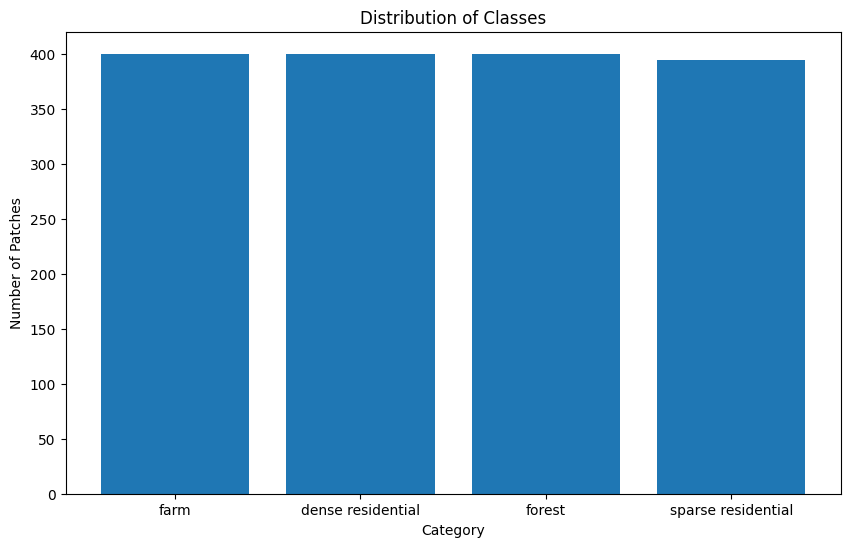

In [ ]:
#Count the occurrences of each class:
class_distribution = Counter(labels_dataset)

print("Class distribution:")
for category, count in class_distribution.items():
  print(f"{category}: {count}")

# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title("Distribution of Classes")
plt.xlabel("Category")
plt.ylabel("Number of Patches")
plt.show()

In [ ]:
#Calculate the percentage of each class:
total_patches = len(labels_dataset)
for category, count in class_distribution.items():
  percentage = (count / total_patches) * 100
  print(f"{category}: {percentage:.2f}%")

farm: 25.09%
dense residential: 25.09%
forest: 25.09%
sparse residential: 24.72%


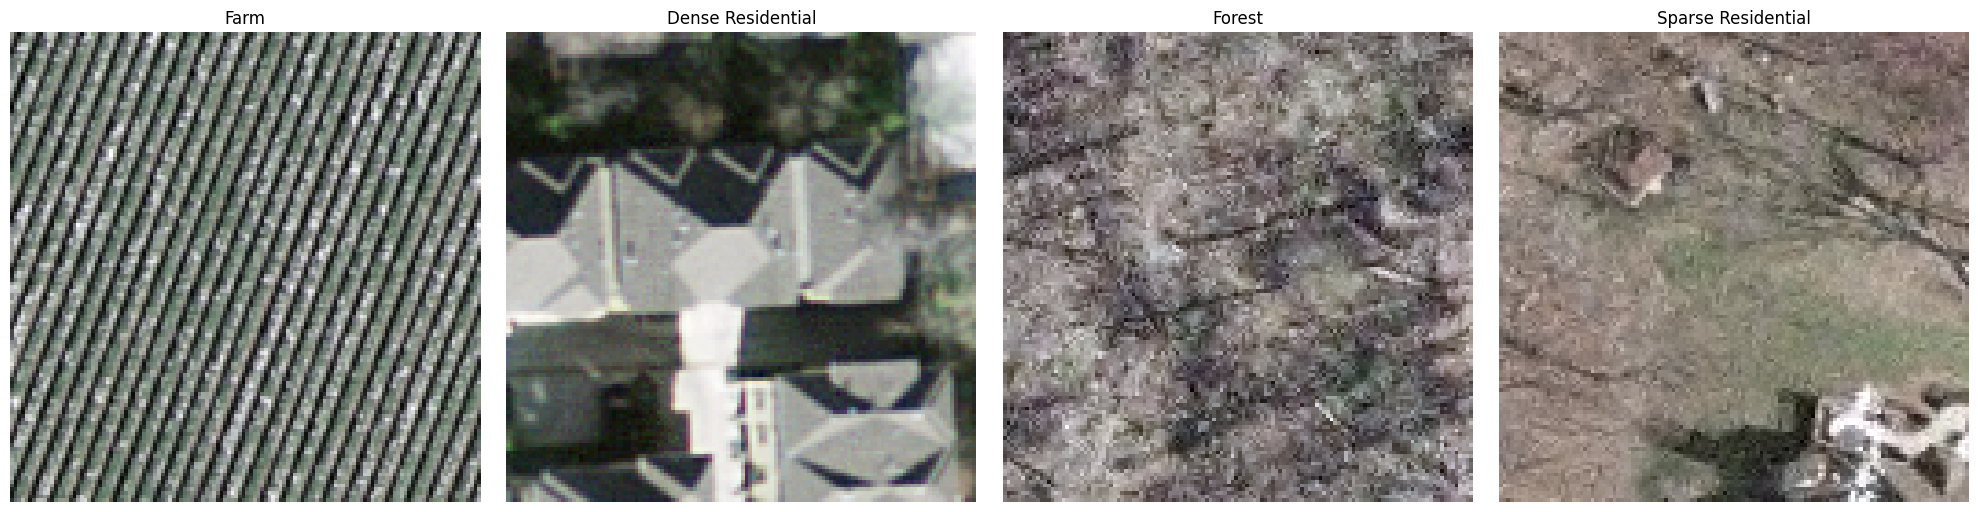

In [ ]:
#Display sample images from each category:
plt.figure(figsize=(20, 5))
for i, category in enumerate(categories):
  category_indices = np.where(labels_dataset == category.lower())[0]
  random_index = np.random.choice(category_indices)
  plt.subplot(1, 4, i+1)
  plt.imshow(image_dataset[random_index])
  plt.title(category)
  plt.axis('off')
plt.tight_layout()
plt.show()

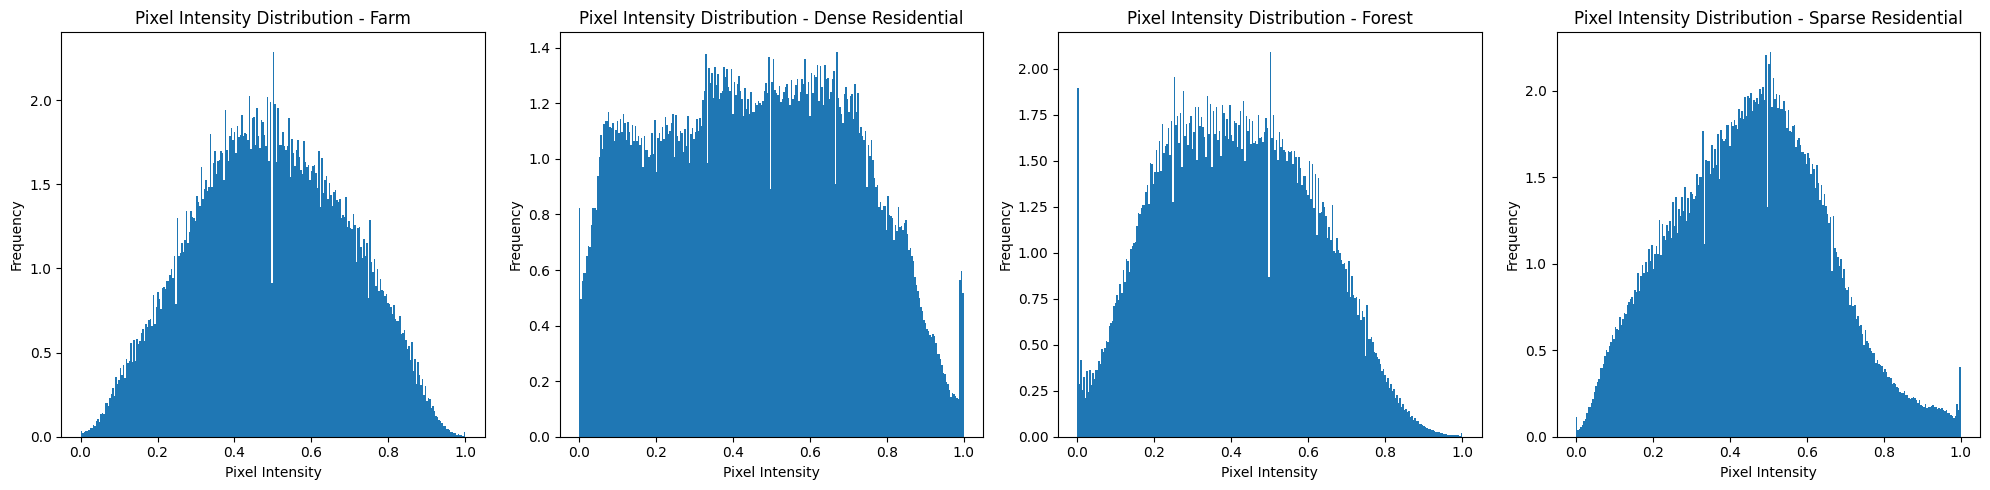

In [ ]:
#Analyze pixel intensity distribution for each category:
plt.figure(figsize=(20, 5))
for i, category in enumerate(categories):
  category_indices = np.where(labels_dataset == category.lower())[0]
  category_images = image_dataset[category_indices]
  plt.subplot(1, 4, i+1)
  plt.hist(category_images.ravel(), bins=256, range=(0, 1), density=True)
  plt.title(f"Pixel Intensity Distribution - {category}")
  plt.xlabel("Pixel Intensity")
  plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

1. Farm: The distribution is roughly symmetric, peaking around the middle intensity values. This suggests a balanced range of pixel intensities, indicating a mix of light and dark areas.
2. Dense Residential: The distribution is more uniform, with a slight peak towards higher intensities. This could indicate a prevalence of brighter areas, possibly due to reflective surfaces or artificial lighting.
3. Forest: The distribution is similar to the Farm category, with a peak around the middle. This suggests a mix of shadows and sunlight typical of forested areas.
4. Sparse Residential: The distribution is also symmetric, with a peak around the middle. This indicates a mix of open spaces and structures, leading to varied pixel intensities.

# Training and testing Dataset

In [ ]:
image_dataset = augmented_image_dataset
mask_dataset = augmented_mask_dataset
labels_dataset = augmented_labels_dataset
mask_dataset.shape

(2400, 128, 128, 1)

In [ ]:
total_classes = len(np.unique(mask_dataset))
total_classes

3

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
mask_dataset[90]

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]])

In [ ]:
labels_categorical_dataset = to_categorical(mask_dataset, num_classes=total_classes)

In [ ]:
labels_categorical_dataset[90]

array([[[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       ...,

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]]], dtype=float32)

In [ ]:
labels_categorical_dataset

array([[[[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        ...,

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]]],


       [[[1., 0., 0.],
         [1., 0., 0.],
         [1., 

In [ ]:
image_dataset.shape

(2400, 128, 128, 3)

In [ ]:
master_trianing_dataset = image_dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.30, random_state=100)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1680, 128, 128, 3)
(720, 128, 128, 3)
(1680, 128, 128, 3)
(720, 128, 128, 3)


In [ ]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

128
128
3
3


# Deep Learning with Satellite Imagery Data

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [ ]:
from keras import backend as K

In [ ]:
#https://en.wikipedia.org/wiki/Jaccard_index
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [ ]:
def multi_unet_model(n_classes=3, image_height=128, image_width=128, image_channels=3):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(8, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.1)(c1) #drop 10% value
  c1 = Conv2D(8, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.1)(c2)
  c2 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.1)(c3)
  c3 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.1)(c4)
  c4 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.1)(c5)
  c5 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.1)(c6)
  c6 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(8, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(8, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(8, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [ ]:
metrics = ["accuracy", jaccard_coef]

In [ ]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [ ]:
model = get_deep_learning_model()

In [ ]:
model.get_config()

{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 128, 128, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 8,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'Dropout',
   'config': {'name': 'd

#Generating Loss Function

*   dice loss > Focal Loss > Total Loss
*   Total Loss = (Dice loss + (1*Focal Loss))



In [ ]:
import segmentation_models as sm

In [ ]:
weights = [0.33,0.33,0.33] # 3 classes so equal weight 1/3

In [ ]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [ ]:
total_loss

#Model compilation

In [ ]:
import tensorflow as tf

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 8)  224         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 8)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 8)  584         ['dropout[0][0]']            

#Visualize Model with Keras

In [ ]:
import keras
from IPython.display import clear_output

%matplotlib inline

In [ ]:
!pip install wandb -qU

In [ ]:
!pip install --upgrade wandb

In [ ]:
# Log in to your W&B account
import wandb
# Use wandb-core, temporary for wandb's new backend
wandb.require("core")
#from wandb.keras import WandbCallback
from wandb.integration.keras import WandbCallback

wandb: WARNING `wandb.require('core')` is redundant as it is now the default behavior.


In [ ]:
wandb.init(project="satellite-imagery", entity="shah-shivani1993-university-of-south-australia")

accuracy,▄▅▇▇████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
jaccard_coef,▁▃▃▃▄▇▇▇▇████████
loss,█▅▅▄▃▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▃▄▅▅▇▇████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_jaccard_coef,▁▆▇▇▇▇▇████████
val_loss,█▅▃▂▃▂▂▂▂▁▁▁▁▂▁▁▁▂▁
accuracy,0.32098
best_epoch,37
best_val_loss,0.6823
epoch,149


In [ ]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
!wandb status

Current Settings
{
  "_extra_http_headers": null,
  "_proxies": null,
  "api_key": null,
  "base_url": "https://api.wandb.ai",
  "entity": null,
  "git_remote": "origin",
  "ignore_globs": [],
  "project": null,
  "root_dir": null,
  "section": "default"
}


In [ ]:
wandb.log({'accuracy': jaccard_coef, 'loss': total_loss})
wandb.config.dropout = 0.1

(1920, 128, 128, 3)
(480, 128, 128, 3)
(1920, 128, 128, 3)
(480, 128, 128, 3)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
#accuracy of train dataset
model_history = model.fit(X_train, y_train,
                          batch_size=16, #give based on total X_train dataset so 1680/32 = 60 times loop
                          verbose=1,
                          epochs=100, #going to run 50 times , once validate we will see with 50 or 70 or 100
                          validation_data=(X_test, y_test),
                          callbacks=[WandbCallback()], #for weight bias platform WandbEvalCallback
                          shuffle=False)

Epoch 1/100
105/105 [==============================] - ETA: 0s - loss: 0.9173 - accuracy: 0.4404 - jaccard_coef: 0.2391

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 26s 225ms/step - loss: 0.9173 - accuracy: 0.4404 - jaccard_coef: 0.2391 - val_loss: 0.8827 - val_accuracy: 0.5573 - val_jaccard_coef: 0.3003
Epoch 2/100
105/105 [==============================] - ETA: 0s - loss: 0.8310 - accuracy: 0.6890 - jaccard_coef: 0.4487

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 23s 223ms/step - loss: 0.8310 - accuracy: 0.6890 - jaccard_coef: 0.4487 - val_loss: 0.8114 - val_accuracy: 0.7505 - val_jaccard_coef: 0.5123
Epoch 3/100
105/105 [==============================] - ETA: 0s - loss: 0.7974 - accuracy: 0.7683 - jaccard_coef: 0.5560

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 23s 221ms/step - loss: 0.7974 - accuracy: 0.7683 - jaccard_coef: 0.5560 - val_loss: 0.8097 - val_accuracy: 0.7554 - val_jaccard_coef: 0.5466
Epoch 4/100
105/105 [==============================] - 19s 183ms/step - loss: 0.7802 - accuracy: 0.7971 - jaccard_coef: 0.6048 - val_loss: 0.8484 - val_accuracy: 0.7047 - val_jaccard_coef: 0.4938
Epoch 5/100
105/105 [==============================] - ETA: 0s - loss: 0.7723 - accuracy: 0.8172 - jaccard_coef: 0.6322

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 23s 220ms/step - loss: 0.7723 - accuracy: 0.8172 - jaccard_coef: 0.6322 - val_loss: 0.7996 - val_accuracy: 0.7782 - val_jaccard_coef: 0.5700
Epoch 6/100
105/105 [==============================] - ETA: 0s - loss: 0.7633 - accuracy: 0.8470 - jaccard_coef: 0.6764

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 23s 223ms/step - loss: 0.7633 - accuracy: 0.8470 - jaccard_coef: 0.6764 - val_loss: 0.7722 - val_accuracy: 0.8354 - val_jaccard_coef: 0.6126
Epoch 7/100
105/105 [==============================] - ETA: 0s - loss: 0.7485 - accuracy: 0.8742 - jaccard_coef: 0.7233

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 24s 226ms/step - loss: 0.7485 - accuracy: 0.8742 - jaccard_coef: 0.7233 - val_loss: 0.7674 - val_accuracy: 0.8479 - val_jaccard_coef: 0.6967
Epoch 8/100
105/105 [==============================] - ETA: 0s - loss: 0.7338 - accuracy: 0.9033 - jaccard_coef: 0.7825

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 23s 220ms/step - loss: 0.7338 - accuracy: 0.9033 - jaccard_coef: 0.7825 - val_loss: 0.7347 - val_accuracy: 0.9043 - val_jaccard_coef: 0.7763
Epoch 9/100
105/105 [==============================] - ETA: 0s - loss: 0.7261 - accuracy: 0.9177 - jaccard_coef: 0.8097

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 23s 224ms/step - loss: 0.7261 - accuracy: 0.9177 - jaccard_coef: 0.8097 - val_loss: 0.7309 - val_accuracy: 0.9102 - val_jaccard_coef: 0.8044
Epoch 10/100
105/105 [==============================] - 19s 182ms/step - loss: 0.7282 - accuracy: 0.9108 - jaccard_coef: 0.8047 - val_loss: 0.7320 - val_accuracy: 0.9092 - val_jaccard_coef: 0.8074
Epoch 11/100
105/105 [==============================] - ETA: 0s - loss: 0.7189 - accuracy: 0.9292 - jaccard_coef: 0.8390

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 24s 225ms/step - loss: 0.7189 - accuracy: 0.9292 - jaccard_coef: 0.8390 - val_loss: 0.7184 - val_accuracy: 0.9338 - val_jaccard_coef: 0.8327
Epoch 12/100
105/105 [==============================] - 19s 183ms/step - loss: 0.7153 - accuracy: 0.9333 - jaccard_coef: 0.8500 - val_loss: 0.7186 - val_accuracy: 0.9340 - val_jaccard_coef: 0.8491
Epoch 13/100
105/105 [==============================] - ETA: 0s - loss: 0.7088 - accuracy: 0.9438 - jaccard_coef: 0.8712

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 23s 223ms/step - loss: 0.7088 - accuracy: 0.9438 - jaccard_coef: 0.8712 - val_loss: 0.7120 - val_accuracy: 0.9373 - val_jaccard_coef: 0.8621
Epoch 14/100
105/105 [==============================] - 19s 183ms/step - loss: 0.7108 - accuracy: 0.9423 - jaccard_coef: 0.8694 - val_loss: 0.7407 - val_accuracy: 0.9062 - val_jaccard_coef: 0.7571
Epoch 15/100
105/105 [==============================] - ETA: 0s - loss: 0.7086 - accuracy: 0.9430 - jaccard_coef: 0.8674

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 24s 226ms/step - loss: 0.7086 - accuracy: 0.9430 - jaccard_coef: 0.8674 - val_loss: 0.7117 - val_accuracy: 0.9406 - val_jaccard_coef: 0.8673
Epoch 16/100
105/105 [==============================] - ETA: 0s - loss: 0.6965 - accuracy: 0.9635 - jaccard_coef: 0.9115

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 23s 224ms/step - loss: 0.6965 - accuracy: 0.9635 - jaccard_coef: 0.9115 - val_loss: 0.7105 - val_accuracy: 0.9439 - val_jaccard_coef: 0.8754
Epoch 17/100
105/105 [==============================] - ETA: 0s - loss: 0.6967 - accuracy: 0.9610 - jaccard_coef: 0.9105

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 23s 219ms/step - loss: 0.6967 - accuracy: 0.9610 - jaccard_coef: 0.9105 - val_loss: 0.7054 - val_accuracy: 0.9466 - val_jaccard_coef: 0.8834
Epoch 18/100
105/105 [==============================] - ETA: 0s - loss: 0.6973 - accuracy: 0.9621 - jaccard_coef: 0.9089

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 23s 223ms/step - loss: 0.6973 - accuracy: 0.9621 - jaccard_coef: 0.9089 - val_loss: 0.7052 - val_accuracy: 0.9478 - val_jaccard_coef: 0.8911
Epoch 19/100
105/105 [==============================] - 20s 187ms/step - loss: 0.6973 - accuracy: 0.9588 - jaccard_coef: 0.9088 - val_loss: 0.7106 - val_accuracy: 0.9409 - val_jaccard_coef: 0.8752
Epoch 20/100
105/105 [==============================] - 19s 184ms/step - loss: 0.6946 - accuracy: 0.9661 - jaccard_coef: 0.9176 - val_loss: 0.7068 - val_accuracy: 0.9465 - val_jaccard_coef: 0.8878
Epoch 21/100
105/105 [==============================] - ETA: 0s - loss: 0.6991 - accuracy: 0.9570 - jaccard_coef: 0.9016

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 24s 227ms/step - loss: 0.6991 - accuracy: 0.9570 - jaccard_coef: 0.9016 - val_loss: 0.7020 - val_accuracy: 0.9589 - val_jaccard_coef: 0.9009
Epoch 22/100
105/105 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.9681 - jaccard_coef: 0.9231

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 23s 221ms/step - loss: 0.6932 - accuracy: 0.9681 - jaccard_coef: 0.9231 - val_loss: 0.7006 - val_accuracy: 0.9607 - val_jaccard_coef: 0.9062
Epoch 23/100
105/105 [==============================] - 19s 183ms/step - loss: 0.6922 - accuracy: 0.9699 - jaccard_coef: 0.9306 - val_loss: 0.7062 - val_accuracy: 0.9499 - val_jaccard_coef: 0.8916
Epoch 24/100
105/105 [==============================] - 20s 187ms/step - loss: 0.6903 - accuracy: 0.9711 - jaccard_coef: 0.9306 - val_loss: 0.7027 - val_accuracy: 0.9562 - val_jaccard_coef: 0.9065
Epoch 25/100
105/105 [==============================] - ETA: 0s - loss: 0.6955 - accuracy: 0.9658 - jaccard_coef: 0.9199

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 24s 225ms/step - loss: 0.6955 - accuracy: 0.9658 - jaccard_coef: 0.9199 - val_loss: 0.6954 - val_accuracy: 0.9683 - val_jaccard_coef: 0.9221
Epoch 26/100
105/105 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.9682 - jaccard_coef: 0.9256

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 23s 223ms/step - loss: 0.6920 - accuracy: 0.9682 - jaccard_coef: 0.9256 - val_loss: 0.6930 - val_accuracy: 0.9694 - val_jaccard_coef: 0.9309
Epoch 27/100
105/105 [==============================] - 19s 185ms/step - loss: 0.6858 - accuracy: 0.9783 - jaccard_coef: 0.9481 - val_loss: 0.7054 - val_accuracy: 0.9529 - val_jaccard_coef: 0.8955
Epoch 28/100
105/105 [==============================] - 20s 187ms/step - loss: 0.6919 - accuracy: 0.9708 - jaccard_coef: 0.9294 - val_loss: 0.7015 - val_accuracy: 0.9579 - val_jaccard_coef: 0.9099
Epoch 29/100
105/105 [==============================] - ETA: 0s - loss: 0.6846 - accuracy: 0.9805 - jaccard_coef: 0.9521

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 23s 224ms/step - loss: 0.6846 - accuracy: 0.9805 - jaccard_coef: 0.9521 - val_loss: 0.6895 - val_accuracy: 0.9760 - val_jaccard_coef: 0.9441
Epoch 30/100
105/105 [==============================] - 20s 187ms/step - loss: 0.6864 - accuracy: 0.9770 - jaccard_coef: 0.9468 - val_loss: 0.6910 - val_accuracy: 0.9743 - val_jaccard_coef: 0.9373
Epoch 31/100
105/105 [==============================] - 19s 184ms/step - loss: 0.6928 - accuracy: 0.9680 - jaccard_coef: 0.9263 - val_loss: 0.6958 - val_accuracy: 0.9670 - val_jaccard_coef: 0.9290
Epoch 32/100
105/105 [==============================] - ETA: 0s - loss: 0.6859 - accuracy: 0.9774 - jaccard_coef: 0.9465

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 23s 223ms/step - loss: 0.6859 - accuracy: 0.9774 - jaccard_coef: 0.9465 - val_loss: 0.6871 - val_accuracy: 0.9772 - val_jaccard_coef: 0.9479
Epoch 33/100
105/105 [==============================] - 19s 182ms/step - loss: 0.6868 - accuracy: 0.9757 - jaccard_coef: 0.9430 - val_loss: 0.6888 - val_accuracy: 0.9774 - val_jaccard_coef: 0.9447
Epoch 34/100
105/105 [==============================] - 20s 186ms/step - loss: 0.6870 - accuracy: 0.9758 - jaccard_coef: 0.9411 - val_loss: 0.6933 - val_accuracy: 0.9724 - val_jaccard_coef: 0.9366
Epoch 35/100
105/105 [==============================] - 19s 186ms/step - loss: 0.6825 - accuracy: 0.9827 - jaccard_coef: 0.9584 - val_loss: 0.7041 - val_accuracy: 0.9573 - val_jaccard_coef: 0.9089
Epoch 36/100
105/105 [==============================] - 19s 184ms/step - loss: 0.6848 - accuracy: 0.9792 - jaccard_coef: 0.9512 - val_loss: 0.6882 - val_accuracy: 0.9779 - val_jaccard_coef: 0.9506
Epoch 37/100
105/105 [======

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 23s 216ms/step - loss: 0.6821 - accuracy: 0.9839 - jaccard_coef: 0.9605 - val_loss: 0.6853 - val_accuracy: 0.9840 - val_jaccard_coef: 0.9577
Epoch 46/100
105/105 [==============================] - 19s 184ms/step - loss: 0.6861 - accuracy: 0.9768 - jaccard_coef: 0.9466 - val_loss: 0.6913 - val_accuracy: 0.9715 - val_jaccard_coef: 0.9383
Epoch 47/100
105/105 [==============================] - 19s 184ms/step - loss: 0.6908 - accuracy: 0.9725 - jaccard_coef: 0.9376 - val_loss: 0.6858 - val_accuracy: 0.9823 - val_jaccard_coef: 0.9559
Epoch 48/100
105/105 [==============================] - 19s 184ms/step - loss: 0.6787 - accuracy: 0.9880 - jaccard_coef: 0.9704 - val_loss: 0.6894 - val_accuracy: 0.9782 - val_jaccard_coef: 0.9502
Epoch 49/100
105/105 [==============================] - 19s 185ms/step - loss: 0.6770 - accuracy: 0.9898 - jaccard_coef: 0.9754 - val_loss: 0.6918 - val_accuracy: 0.9757 - val_jaccard_coef: 0.9471
Epoch 50/100
105/105 [======

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 23s 224ms/step - loss: 0.6757 - accuracy: 0.9915 - jaccard_coef: 0.9800 - val_loss: 0.6845 - val_accuracy: 0.9840 - val_jaccard_coef: 0.9644
Epoch 60/100
105/105 [==============================] - 19s 185ms/step - loss: 0.6770 - accuracy: 0.9900 - jaccard_coef: 0.9774 - val_loss: 0.6904 - val_accuracy: 0.9790 - val_jaccard_coef: 0.9549
Epoch 61/100
105/105 [==============================] - ETA: 0s - loss: 0.6794 - accuracy: 0.9878 - jaccard_coef: 0.9682

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 24s 227ms/step - loss: 0.6794 - accuracy: 0.9878 - jaccard_coef: 0.9682 - val_loss: 0.6837 - val_accuracy: 0.9863 - val_jaccard_coef: 0.9694
Epoch 62/100
105/105 [==============================] - 19s 184ms/step - loss: 0.6744 - accuracy: 0.9938 - jaccard_coef: 0.9851 - val_loss: 0.6894 - val_accuracy: 0.9802 - val_jaccard_coef: 0.9595
Epoch 63/100
105/105 [==============================] - 19s 183ms/step - loss: 0.6733 - accuracy: 0.9947 - jaccard_coef: 0.9874 - val_loss: 0.6853 - val_accuracy: 0.9837 - val_jaccard_coef: 0.9672
Epoch 64/100
105/105 [==============================] - 19s 183ms/step - loss: 0.6784 - accuracy: 0.9881 - jaccard_coef: 0.9713 - val_loss: 0.6886 - val_accuracy: 0.9807 - val_jaccard_coef: 0.9597
Epoch 65/100
105/105 [==============================] - 20s 187ms/step - loss: 0.6737 - accuracy: 0.9946 - jaccard_coef: 0.9869 - val_loss: 0.6930 - val_accuracy: 0.9753 - val_jaccard_coef: 0.9524
Epoch 66/100
105/105 [======

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 23s 220ms/step - loss: 0.6736 - accuracy: 0.9950 - jaccard_coef: 0.9880 - val_loss: 0.6828 - val_accuracy: 0.9880 - val_jaccard_coef: 0.9759
Epoch 79/100
105/105 [==============================] - 19s 183ms/step - loss: 0.6818 - accuracy: 0.9838 - jaccard_coef: 0.9626 - val_loss: 0.6924 - val_accuracy: 0.9771 - val_jaccard_coef: 0.9554
Epoch 80/100
105/105 [==============================] - 20s 187ms/step - loss: 0.6757 - accuracy: 0.9916 - jaccard_coef: 0.9800 - val_loss: 0.6848 - val_accuracy: 0.9844 - val_jaccard_coef: 0.9682
Epoch 81/100
105/105 [==============================] - 19s 185ms/step - loss: 0.6756 - accuracy: 0.9927 - jaccard_coef: 0.9822 - val_loss: 0.6865 - val_accuracy: 0.9804 - val_jaccard_coef: 0.9611
Epoch 82/100
105/105 [==============================] - ETA: 0s - loss: 0.6736 - accuracy: 0.9947 - jaccard_coef: 0.9873

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 24s 228ms/step - loss: 0.6736 - accuracy: 0.9947 - jaccard_coef: 0.9873 - val_loss: 0.6818 - val_accuracy: 0.9866 - val_jaccard_coef: 0.9746
Epoch 83/100
105/105 [==============================] - ETA: 0s - loss: 0.6710 - accuracy: 0.9987 - jaccard_coef: 0.9962

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 23s 222ms/step - loss: 0.6710 - accuracy: 0.9987 - jaccard_coef: 0.9962 - val_loss: 0.6802 - val_accuracy: 0.9902 - val_jaccard_coef: 0.9799
Epoch 84/100
105/105 [==============================] - 20s 186ms/step - loss: 0.6720 - accuracy: 0.9973 - jaccard_coef: 0.9936 - val_loss: 0.6846 - val_accuracy: 0.9855 - val_jaccard_coef: 0.9719
Epoch 85/100
105/105 [==============================] - 20s 186ms/step - loss: 0.6767 - accuracy: 0.9910 - jaccard_coef: 0.9792 - val_loss: 0.6833 - val_accuracy: 0.9866 - val_jaccard_coef: 0.9712
Epoch 86/100
105/105 [==============================] - 20s 186ms/step - loss: 0.6730 - accuracy: 0.9959 - jaccard_coef: 0.9895 - val_loss: 0.6906 - val_accuracy: 0.9795 - val_jaccard_coef: 0.9577
Epoch 87/100
105/105 [==============================] - 19s 184ms/step - loss: 0.6735 - accuracy: 0.9954 - jaccard_coef: 0.9888 - val_loss: 0.6880 - val_accuracy: 0.9819 - val_jaccard_coef: 0.9638
Epoch 88/100
105/105 [======

wandb: Adding directory to artifact (/content/wandb/run-20241006_030514-h19sooec/files/model-best)... Done. 0.0s


105/105 [==============================] - 23s 218ms/step - loss: 0.6717 - accuracy: 0.9979 - jaccard_coef: 0.9942 - val_loss: 0.6800 - val_accuracy: 0.9906 - val_jaccard_coef: 0.9812


In [ ]:
# Evaluate the model on the train dataset
train_results = model.evaluate(X_train, y_train, verbose=0)

# Print all the metrics
for i, metric_name in enumerate(model.metrics_names):
    print(f"{metric_name}: {train_results[i]:.4f}")

# If you specifically want to access accuracy
train_accuracy = train_results[model.metrics_names.index('accuracy')]
print(f"\nTraining Accuracy: {train_accuracy:.4f}")

loss: 0.6706
accuracy: 0.9992
jaccard_coef: 0.9979

Training Accuracy: 0.9992


In [ ]:
# Evaluate the model on the test dataset
test_results = model.evaluate(X_test, y_test, verbose=0)

# Print all the metrics
for i, metric_name in enumerate(model.metrics_names):
    print(f"{metric_name}: {test_results[i]:.4f}")

# If you specifically want to access accuracy
test_accuracy = test_results[model.metrics_names.index('accuracy')]
print(f"\nTesting Accuracy: {test_accuracy:.4f}")

loss: 0.6774
accuracy: 0.9906
jaccard_coef: 0.9807

Testing Accuracy: 0.9906


23/23 [==============================] - 1s 50ms/step


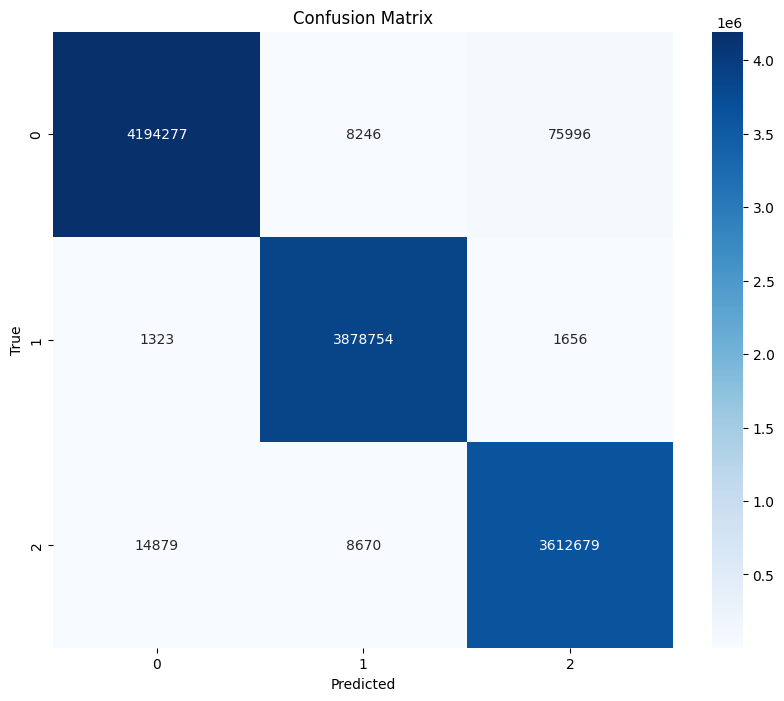

                   precision    recall  f1-score   support

             Farm       1.00      0.98      0.99   4278519
Dense Residential       1.00      1.00      1.00   3881733
           Forest       0.98      0.99      0.99   3636228

         accuracy                           0.99  11796480
        macro avg       0.99      0.99      0.99  11796480
     weighted avg       0.99      0.99      0.99  11796480



In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=3)
y_true = np.argmax(y_test, axis=3)

# Flatten the 2D arrays
y_pred_flat = y_pred_classes.flatten()
y_true_flat = y_true.flatten()

# Create confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true_flat, y_pred_flat, target_names=['Farm', 'Dense Residential', 'Forest']))

In [ ]:
for i, label in enumerate(['Farm', 'Dense Residential', 'Forest']):
  label_accuracy = (y_pred_classes == i).astype(int) == (y_true == i).astype(int)
  label_accuracy = label_accuracy.mean() * 100
  print(f"{label} Accuracy: {label_accuracy:.2f}%")

Farm Accuracy: 99.15%
Dense Residential Accuracy: 99.83%
Forest Accuracy: 99.14%


In [ ]:
history_a = model_history
history_a.history

{'loss': [0.9173394441604614,
  0.8310151100158691,
  0.7974071502685547,
  0.7801675200462341,
  0.7722977995872498,
  0.7633296251296997,
  0.7485369443893433,
  0.7337617874145508,
  0.726066529750824,
  0.7282066941261292,
  0.7189354300498962,
  0.7153064608573914,
  0.7088032960891724,
  0.7108269333839417,
  0.7086184620857239,
  0.6964619755744934,
  0.6966967582702637,
  0.6972765922546387,
  0.6973338723182678,
  0.6945708394050598,
  0.6990986466407776,
  0.6931692361831665,
  0.6922320127487183,
  0.6902908086776733,
  0.6955177783966064,
  0.6919975876808167,
  0.6858040690422058,
  0.6919087767601013,
  0.684596836566925,
  0.6863834857940674,
  0.6928449273109436,
  0.6859293580055237,
  0.6867957711219788,
  0.6870149374008179,
  0.6824752688407898,
  0.6847818493843079,
  0.6803147196769714,
  0.680233895778656,
  0.68122798204422,
  0.6789103746414185,
  0.6765196919441223,
  0.6799306273460388,
  0.6817772388458252,
  0.6798357367515564,
  0.6820650100708008,
  0.686

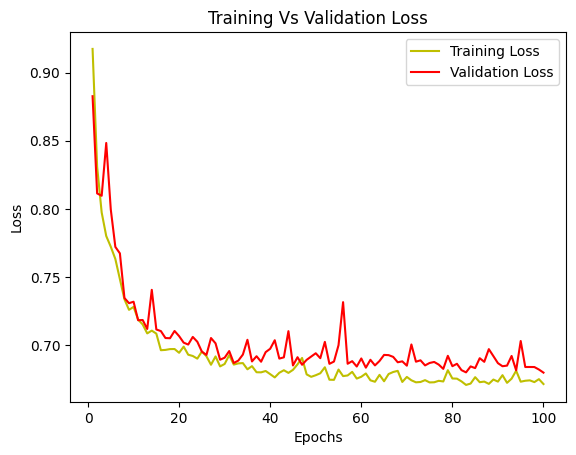

In [ ]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#sepration of validation and training is not bigger and bigger

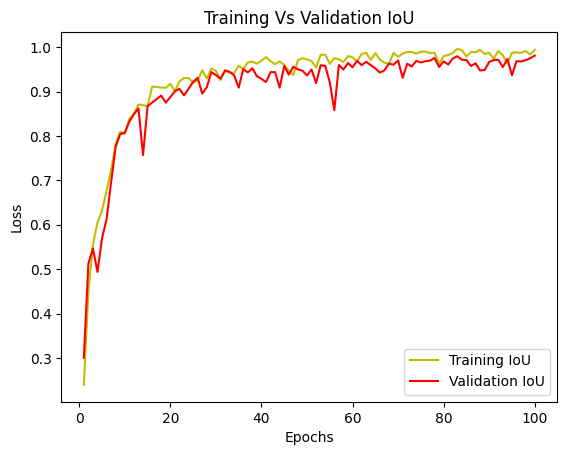

In [ ]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#we need to check this validation IoU, it should be more
#we can reduce dropout while making model

In [ ]:
model_history.params

{'verbose': 1, 'epochs': 100, 'steps': 105}

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1680, 128, 128, 3)
(720, 128, 128, 3)
(1680, 128, 128, 3)
(720, 128, 128, 3)


#Comparing prediction results


*   using test images using images and predicted result images



In [ ]:
print("Unique values in y_pred_flat:", np.unique(y_pred_flat))
print("Unique values in y_true_flat:", np.unique(y_true_flat))

Unique values in y_pred_flat: [0]
Unique values in y_true_flat: [0]


In [ ]:
print("Unique values in ground_truth_image:", np.unique(np.argmax(ground_truth_image, axis=-1)))
print("Unique values in predicted_class_image:", np.unique(predicted_class_image))

Unique values in ground_truth_image: [0]
Unique values in predicted_class_image: [0]


1/1 [==============================] - 0s 35ms/step


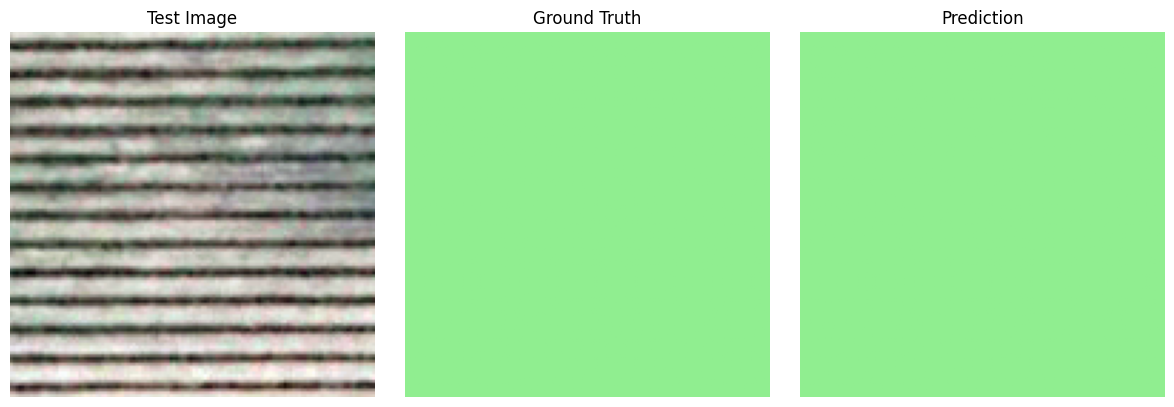

              precision    recall  f1-score   support

        Farm       1.00      1.00      1.00     16384

    accuracy                           1.00     16384
   macro avg       1.00      1.00      1.00     16384
weighted avg       1.00      1.00      1.00     16384



In [ ]:
import random

# Select a random test image
test_image_number = random.randint(0, len(X_test) - 1)

test_image = X_test[test_image_number]
ground_truth_image = y_test[test_image_number]
prediction_image = model.predict(np.expand_dims(test_image, axis=0))[0]
predicted_class_image = np.argmax(prediction_image, axis=-1)

# Apply color mapping
ground_truth_colored = apply_color_mapping(np.argmax(ground_truth_image, axis=-1))
prediction_colored = apply_color_mapping(predicted_class_image)

plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.title('Test Image')
plt.imshow(test_image)
plt.axis('off')

plt.subplot(132)
plt.title('Ground Truth')
plt.imshow(ground_truth_colored)
plt.axis('off')

plt.subplot(133)
plt.title('Prediction')
plt.imshow(prediction_colored)
plt.axis('off')

plt.tight_layout()
plt.show()

# Print classification report
y_pred_flat = predicted_class_image.flatten()
y_true_flat = np.argmax(ground_truth_image, axis=-1).flatten()

unique_classes = np.unique(np.concatenate((y_true_flat, y_pred_flat)))
target_names = [['Farm', 'Dense Residential', 'Forest'][i] for i in unique_classes]

print(classification_report(y_true_flat, y_pred_flat, target_names=target_names))

#Model save and reload

In [ ]:
from keras.models import load_model

In [ ]:
model.save("satellite_segmentation_full.h5")

In [ ]:
saved_model = load_model('drive/MyDrive/Colab Notebooks/satellite/satellite_segmentation_full.h5',
                         custom_objects=({'dice_loss_plus_1focal_loss': total_loss,
                                          'jaccard_coef': jaccard_coef}))

In [ ]:
saved_model.get_config()

{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 128, 128, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 8,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'Dropout',
   'config': {'name': 'd

##New Image Prediction

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [ ]:
# Initialize MinMaxScaler
minmaxscaler = MinMaxScaler()

# Initialize an empty list to store patches from images
image_dataset = []

# Define patch size
patch_size = 128

In [ ]:
# Load the image
full_path = os.path.abspath(os.path.join(base_input_folder, "image-5.png"))

In [ ]:
full_path

'/content/drive/MyDrive/Colab Notebooks/satellite/image-5.png'

In [ ]:
image = cv2.imread(full_path, 1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Check if the image dimensions are smaller than the patch size
if image.shape[0] < patch_size or image.shape[1] < patch_size:
    print(f"Warning: Image {full_path} is smaller than patch size, skipping.")
else:
    SIZE_X = (image.shape[1] // patch_size) * patch_size  # Nearest size divisible by patch size
    SIZE_Y = (image.shape[0] // patch_size) * patch_size  # Nearest size divisible by patch size

    # Crop the image to the nearest size divisible by patch size
    image = Image.fromarray(image)
    image = image.crop((0, 0, SIZE_X, SIZE_Y))
    image = np.array(image)

    # Extract patches from the image
    print(f"Now patchifying image: {full_path}")
    patches_image = patchify(image, (patch_size, patch_size, 3), step=patch_size)  # Step=128 means no overlap

    # Iterate through patches and add them to the dataset
    for i in range(patches_image.shape[0]):
        for j in range(patches_image.shape[1]):
            individual_patched_image = patches_image[i,j,:,:]
            #normalise dataset with minmaxscaler
            individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
            individual_patched_image = individual_patched_image[0]
            image_dataset.append(individual_patched_image)

# Convert image_dataset to numpy array
image_dataset = np.array(image_dataset)

print(f"Number of patches: {len(image_dataset)}")
print(f"Shape of each patch: {image_dataset[0].shape}")

Now patchifying image: /content/drive/MyDrive/Colab Notebooks/satellite/image-5.png
Number of patches: 72
Shape of each patch: (128, 128, 3)


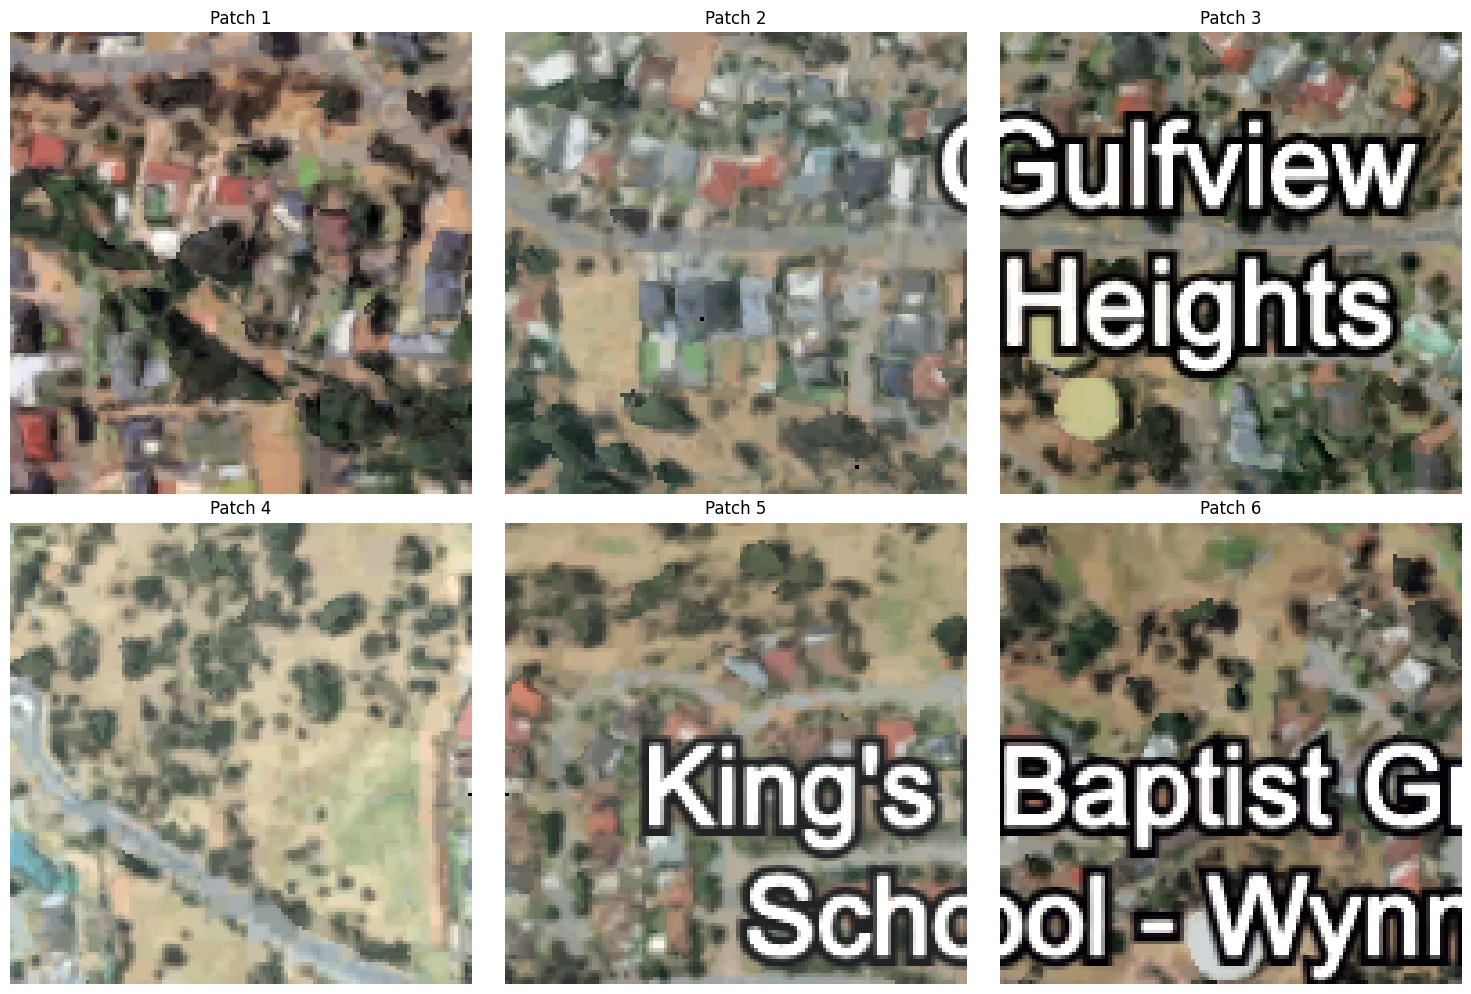

In [ ]:
# Visualize a few patches
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()):
    if i < len(image_dataset):
        ax.imshow(image_dataset[i])
        ax.axis('off')
        ax.set_title(f"Patch {i+1}")
plt.tight_layout()
plt.show()

In [ ]:
# Make predictions
predictions = saved_model.predict(image_dataset)
predicted_classes = np.argmax(predictions, axis=3)

3/3 [==============================] - 0s 57ms/step


In [ ]:
predicted_classes

array([[[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        ...,
        [1, 1, 1, ..., 

In [ ]:
# Reconstruct the full predicted image
def reconstruct_from_patches(patches, original_size):
  height, width = original_size
  patch_size = patches.shape[1]
  rows = height // patch_size
  cols = width // patch_size
  reconstructed = np.zeros((rows * patch_size, cols * patch_size), dtype=np.uint8)
  index = 0
  for i in range(rows):
      for j in range(cols):
          reconstructed[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = patches[index]
          index += 1
  return reconstructed

In [ ]:
# Get the original image size
original_size = (SIZE_Y, SIZE_X)  # Using SIZE_Y and SIZE_X from the patchify step

predicted_image = reconstruct_from_patches(predicted_classes, original_size)

# Calculate class proportions
y_pred = predicted_image.flatten()
class_proportions = np.bincount(y_pred, minlength=len(label_mapping)) / len(y_pred) * 100

print("Class Proportions:")
for i, class_name in enumerate(label_mapping.keys()):
  print(f"{class_name.capitalize()}: {class_proportions[i]:.2f}%")


Class Proportions:
Farm: 7.19%
Dense residential: 48.82%
Forest: 43.98%


In [ ]:
# Visualize the results
colors = [color_mapping[i] for i in range(len(label_mapping))]
custom_cmap = plt.cm.colors.ListedColormap(colors)

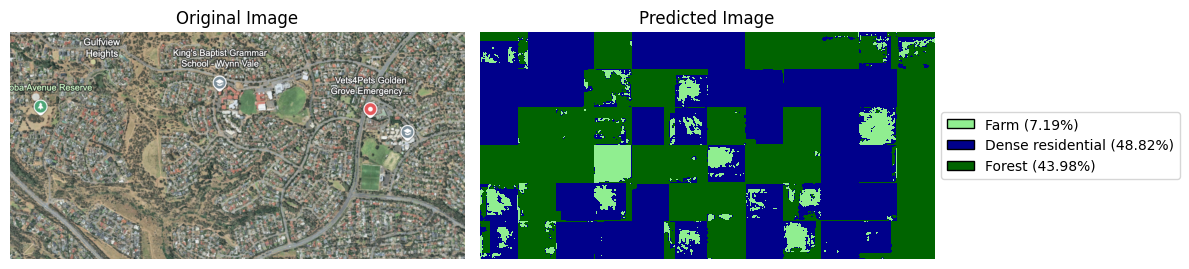

In [ ]:
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(121)
plt.title("Original Image")
plt.imshow(image)  # Using the original image before patchifying
plt.axis('off')

# Predicted Image
plt.subplot(122)
plt.title("Predicted Image")
plt.imshow(predicted_image, cmap=custom_cmap, vmin=0, vmax=len(label_mapping)-1)
plt.axis('off')

# Create custom legend
legend_elements = [mpatches.Patch(facecolor=color_mapping[i], edgecolor='black',
                                label=f"{list(label_mapping.keys())[i].capitalize()} ({class_proportions[i]:.2f}%)")
                 for i in range(len(label_mapping))]

# Add the legend to the plot
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()